In [58]:
import anuga, anuga.parallel, numpy, time, os, glob
from anuga.operators.rate_operators import Polygonal_rate_operator
from anuga import file_function, Polygon_function, read_polygon, create_mesh_from_regions, Domain, Inlet_operator
import anuga.utilities.spatialInputUtil as su
from anuga import distribute, myid, numprocs, finalize, barrier
from anuga.parallel.parallel_operator_factory import Inlet_operator, Boyd_box_operator, Boyd_pipe_operator
from anuga import Rate_operator
from anuga import Region

import os
import numpy as np
from hymo import SWMMInpFile
import pickle
from pyswmm import Simulation, Nodes, Links, SystemStats
import matplotlib.pyplot as plt

import time
from coupling_functions.inlet_initialization import initialize_inlets
from coupling_functions.coupling import calculate_Q, calculate_Q_v2
import matplotlib

time_average = 10 # sec
dt           = 1.0    # yield step
ft           = 75 # final timestep

plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 10})
co = 0.2
cw = 0.2

output_frequency = 1
do_print         = True
do_data_save     = True
do_plot          = True

basename = 'model/terrain'
# inp_name = 'real_example_inflow_max_sur_depth.inp'
inp_name = 'real_example_ts_ea_node.inp'

outname  = inp_name
meshname = 'model/terrain.tsh'

sim = Simulation(inp_name)
inp = SWMMInpFile(inp_name)
# baseline_flow = inp.inflows.Baseline.values[0]
baseline_flow = 0.5


if os.path.isdir('plots/') and do_plot:
    plot_path = 'plots/'
    plot_name = plot_path + f'volume_and_loss_inflow_{baseline_flow}_tavg_{time_average}_surd_{inp.junctions.loc["Inlet_3"].Surcharge_Depth}_maxd_{inp.junctions.loc["Inlet_3"].Max_Depth}'

#------------------------------------------------------------------------------
# CREATING MESH
#------------------------------------------------------------------------------
riverWall_csv_files = glob.glob('model/wall/*.csv') # Make a list of the csv files in BREAKLINES

(riverWalls, riverWall_parameters) = su.readListOfRiverWalls(riverWall_csv_files)

CatchmentDictionary = {'model/kerb/kerb1.csv':0.01, 'model/kerb/kerb2.csv':0.01}
    
bounding_polygon = anuga.read_polygon('model/domain.csv')
interior_regions = anuga.read_polygon_dir(CatchmentDictionary, 'model/kerb')


create_mesh_from_regions(bounding_polygon,
    boundary_tags={'inflow': [12], 'bottom': [0,1,2,3,4,5], 'top': [7,8,9,10,11], 'outflow': [6]},
    #boundary_tags=None,
    maximum_triangle_area = 0.25,
    breaklines = riverWalls.values(),
    interior_regions = interior_regions,
    filename = meshname,
    use_cache = False,
    verbose = False)

#------------------------------------------------------------------------------
# SETUP COMPUTATIONAL DOMAIN
#------------------------------------------------------------------------------
domain = anuga.Domain(meshname, use_cache=False, verbose=False)
domain.set_minimum_storable_height(0.0)
domain.riverwallData.create_riverwalls(riverWalls,verbose = False) 
domain.set_name(outname) 
# 
#------------------------------------------------------------------------------
# APPLY MANNING'S ROUGHNESSES
#------------------------------------------------------------------------------

domain.set_quantity('friction', 0.025)
domain.set_quantity('stage', 0)
domain.set_quantity('elevation', filename=basename+'.csv', use_cache=False, verbose=False, alpha=0.99)

#------------------------------------------------------------------------------
# SETUP BOUNDARY CONDITIONS
#------------------------------------------------------------------------------
Br = anuga.Reflective_boundary(domain)  
Bd = anuga.Dirichlet_boundary([0,0,0])

# domain.set_boundary({'inflow': Br, 'bottom': Br, 'outflow': Br, 'top': Br})

domain.set_boundary({'inflow': Bd, 'bottom': Bd, 'outflow': Bd, 'top': Bd})

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 10})
# ------------------------------------------------------------------------------
# Setup inject water
# ------------------------------------------------------------------------------

# input1_anuga_region   = Region(domain, radius=1.0, center=(305694.91,6188013.94))
# input1_anuga_inlet_op = Inlet_operator(domain, input1_anuga_region, Q=input_rate) 


# print(f'Loss = {loss:.2f}m^3 of total {t*input_rate}m^3')


Q_rain = [0.25, 0.25, 0.25, 0.25]


 o  Retrieving project data

/home/anton/miniforge3/envs/anuga_env/lib/python3.8/site-packages/anuga/pmesh/mesh_interface.py:190: UserWarning: Segment 13 was not assigned a boundary_tag.Default tag "exterior" will be assigned to missing segment
  warnings.warn(msg, UserWarning)
/home/anton/miniforge3/envs/anuga_env/lib/python3.8/site-packages/anuga/structures/riverwall.py:124: RuntimeWarning: invalid value encountered in cast
  self.hydraulic_properties_rowIndex=numpy.array([default_int]).astype(int)


In [59]:
# from pyswmm import SystemStats, Simulation,Nodes
# import os
# import pickle


# dt = 1
# ft = 200

# sim_test = Simulation(inp_name)

# inlet_rain_flows      = {node.nodeid: [] for node in Nodes(sim_test ) if node.is_junction()}
# inlet_rain_flows_list = []
# inlet_vol_flows       = []
# old_inlet_vol = [0.0 for node in Nodes(sim_test) if node.is_junction()]

# sim_test.start()
# system_routing = SystemStats(sim_test)
# external_inflows  = []
# for t in range(0, ft+dt, dt):

#     for node in Nodes(sim_test):
#         if node.is_junction():
#             inlet_rain_flows[node.nodeid].append(node.lateral_inflow)

#     inlet_rain_flows_list.append([node.lateral_inflow for node in Nodes(sim_test) if node.is_junction()])

#     inlet_vol = [- node.statistics['lateral_infow_vol'] + node.statistics['flooding_volume']
#                     for node in Nodes(sim_test) if node.is_junction()]
#     inlet_flow = [(new_vol - old_vol)/dt for new_vol,
#                     old_vol in zip(inlet_vol, old_inlet_vol)]
#     inlet_vol_flows.append(inlet_flow)
#     # inlet_flow = [node.lateral_inflow for node in Nodes(sim_test) if node.is_junction()]
#     old_inlet_vol = inlet_vol

#     external_inflows.append(system_routing.routing_stats['external_inflow'])
#     sim_test.step_advance(dt)
#     sim_test.next()
#     print(t)
# plt.plot(range(0, ft+dt, dt), np.array(inlet_vol_flows))
# plt.plot(external_inflows)

In [60]:

node_ids      = [node.nodeid for node in Nodes(sim)]
in_node_ids   = [node.nodeid for node in Nodes(sim) if node.is_junction()]
n_in_nodes    = len(in_node_ids)


### Initialize inlet operators
inlet_area     = np.full((n_in_nodes),1.167)
Q_in_0         = n_in_nodes*[0.0]
Q_in_cumu      = sum(Q_in_0)
inlet_vol_cumu = 0
n_sides        = 6

inlet_operators,inlet_elevation,_,_ = initialize_inlets(domain,sim,inp,n_sides,inlet_area,Q_in_0,rotation = 0)
rain_operators,_,_,_ = initialize_inlets(domain, sim, inp, n_sides, inlet_area, Q_rain, rotation = 0)


inlet_weir_length = 2*np.sqrt(np.pi*inlet_area)


Q_in_old       = np.zeros_like(inlet_elevation)
outfall_vol    = 0

times            = []
losses           = []
outfall_vols     = []
boundary_fluxs    = []
applied_inflows  = []
correct_vols  = []
real_vols     = []
anuga_depths_out = []
sewer_volumes    = []
inlet_floods     = []
domain_volumes   = []
if do_data_save:
    Q_ins          = []
    conduit_depths = []
    node_heads     = []
    cumulative_inlet_flooding = np.array(n_in_nodes*[0.0])
    cumulative_inlet_flow     = np.array(n_in_nodes*[0.0])


system_routing = SystemStats(sim)

In [61]:
old_inlet_flood_vol = [0 for node in Nodes(sim) if node.is_junction()]

In [62]:
invert_elev = [node.invert_elevation for node in Nodes(sim) if node.is_junction()]
max_depths  = [inp.junctions.loc[node.nodeid].Max_Depth for node in Nodes(sim) if node.is_junction()]

Figure files for each frame will be stored in _plot


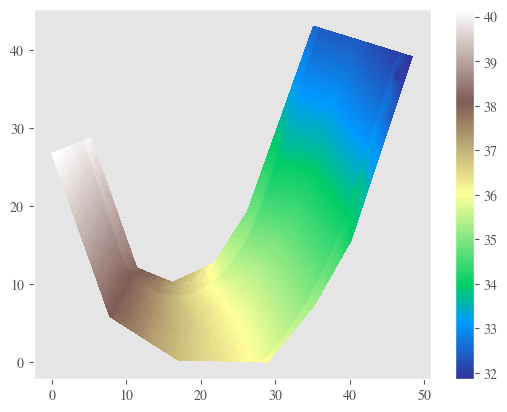

In [63]:
dplotter = anuga.Domain_plotter(domain)
plt.tripcolor(dplotter.triang,
              facecolors = dplotter.elev,
            #   edgecolors='k',
              cmap='terrain')
plt.colorbar()
# plt.triplot(dplotter.triang, linewidth=0.05,color = 'k')

In [64]:
wall_clock_start = time.perf_counter()
sim.start()
old_inlet_vol = [- node.statistics['lateral_infow_vol'] + node.statistics['flooding_volume'] for node in Nodes(sim) if node.is_junction()]
node_volume    = sum(old_inlet_vol)
link_volume_0 = 0
for link in Links(sim):
    link_volume_0 += link.volume

for t in domain.evolve(yieldstep=dt, finaltime=ft):
    anuga_depths = np.array([inlet_operators[in_id].inlet.get_average_depth() for in_id in in_node_ids])


    # Reset link volume at every iteration and sum volumes
    link_volume = 0
    for link in Links(sim):
        link_volume += link.volume

    if do_data_save:
        conduit_depths.append(np.array([link.depth for link in Links(sim)]))



    # outfall_vol         += Links(sim)['Conduit_4'].flow*dt

    outfall_vol         += Nodes(sim)['Outfall_1'].total_inflow*dt
    domain_volume        = domain.get_water_volume()
    sewer_volume         = link_volume + node_volume
    boundary_flux        = domain.get_boundary_flux_integral() # actually volume

    # total_volume_correct = t*baseline_flow + 0.5*baseline_flow + boundary_flux + link_volume_0 - outfall_vol 
    total_volume_correct = t*1.0 + boundary_flux + link_volume_0 - outfall_vol
    total_volume_real    = domain_volume + sewer_volume

    applied_inflow       = (system_routing.routing_stats["external_inflow"] - Q_in_cumu)*dt

    node_head = np.array([node.head for node in Nodes(sim) if node.is_junction()])
    # Q_in       = 1.0 *calculate_Q(node_head, anuga_depths, inlet_elevation, inlet_weir_length, inlet_area, cw, co) # inputs between manual and auto checked to be the same 20/09
    inlet_volumes = [inlet_operators[nodeid].inlet.get_total_water_volume() for nodeid in in_node_ids]
    Q_in = 1.0 * calculate_Q_v2(node_head, anuga_depths, inlet_elevation, inlet_weir_length, inlet_area, inlet_volumes, dt, cw = 0.67, co = 0.67)

    Q_in       = ((time_average - dt)*Q_in_old + dt*Q_in)/time_average
    Q_in_old   = Q_in.copy()
    Q_in_cumu += sum(Q_in)
    
    if do_data_save:
        Q_ins.append(Q_in.copy())
        node_heads.append(node_head.copy())
        anuga_depths_out.append(anuga_depths.copy())


    # Simulate sewer with flow input
    for nodeid, Qin in zip(in_node_ids, Q_in): 
        Nodes(sim)[nodeid].generated_inflow(Qin)      
    sim.step_advance(dt) 
    sim.next()

    ### Using flow methods methods    

    inlet_vol       = [- node.statistics['lateral_infow_vol'] + node.statistics['flooding_volume'] for node in Nodes(sim) if node.is_junction()]

    inlet_flow      = [(new_vol - old_vol)/dt for new_vol,old_vol in zip(inlet_vol,old_inlet_vol)]
    inlet_vol_cumu += sum(inlet_vol)
    old_inlet_vol   = inlet_vol.copy()

    inlet_flood_vol     = [node.statistics['flooding_volume'] for node in Nodes(sim) if node.is_junction()]
    inlet_flood_flow    = [(new_vol - old_vol)/dt for new_vol, old_vol in zip(inlet_flood_vol,old_inlet_flood_vol)]
    old_inlet_flood_vol = inlet_flood_vol.copy()


    inlet_idx = 0
    for node in Nodes(sim):
        if node.is_junction():
            inlet_operators[node.nodeid].set_Q(inlet_flow[inlet_idx] + 0.25)
            inlet_idx += 1

    # inlet_idx = 0
    # for node in Nodes(sim):
    #     if node.is_junction():
    #         inlet_operators[node.nodeid].set_Q(inlet_flood_flow[inlet_idx] - Q_in[inlet_idx])
    #         inlet_idx += 1
          


    applied_inflows.append(applied_inflow)
    correct_vols.append(total_volume_correct)
    real_vols.append(total_volume_real)
    outfall_vols.append(outfall_vol)
    loss = total_volume_real - total_volume_correct
    losses.append(loss)
    sewer_volumes.append(sewer_volume)
    domain_volumes.append(domain_volume)
    boundary_fluxs.append(boundary_flux)
    inlet_floods.append(inlet_flood_flow)

    if do_data_save:
        cumulative_inlet_flooding += np.array([node.flooding for node in Nodes(sim) if node.is_junction()])
        cumulative_inlet_flow     += np.array(inlet_flow)*dt
    times.append(t)
    
    if domain.yieldstep_counter%output_frequency == 0 and do_print:
        print('\nt = ',t)
        print(f'Q_in = {Q_in}')
        print(sim.current_time)
        # print(f'-sum(inlet_vol) + Q_in_cumu -: {-sum(inlet_vol) + Q_in_cumu- sum(inlet_flood_vol):.4f}')
    # sim.step_advance(dt) 
    # sim.next()

sim.report()
# sim.close()
wall_clock_end = time.perf_counter()
print('\n')
print(40*'#')
print(f'Loss : {loss}')
print(f'\nComputation time: {wall_clock_end - wall_clock_start:.2f} seconds')



t =  0.0
Q_in = [0. 0. 0. 0.]
2022-09-08 00:00:01

t =  1.0
Q_in = [0.0375 0.0375 0.0375 0.0375]
2022-09-08 00:00:02

t =  2.0
Q_in = [0.05944748 0.06048176 0.05906656 0.06070532]
2022-09-08 00:00:03

t =  3.0
Q_in = [0.07691768 0.07989245 0.07623923 0.07894841]
2022-09-08 00:00:04

t =  4.0
Q_in = [0.09187987 0.09713692 0.11182887 0.0941503 ]
2022-09-08 00:00:05

t =  5.0
Q_in = [0.1048561  0.11212602 0.14503865 0.10716435]
2022-09-08 00:00:06

t =  6.0
Q_in = [0.11573729 0.12673031 0.17682798 0.11794604]
2022-09-08 00:00:07

t =  7.0
Q_in = [0.12454184 0.14040208 0.20822195 0.1265159 ]
2022-09-08 00:00:08

t =  8.0
Q_in = [0.13147491 0.15278916 0.24055402 0.1331791 ]
2022-09-08 00:00:09

t =  9.0
Q_in = [0.13690638 0.16332599 0.27101659 0.13833795]
2022-09-08 00:00:10

t =  10.0
Q_in = [0.14115156 0.17200907 0.29939494 0.14233373]
2022-09-08 00:00:11

t =  11.0
Q_in = [0.14443692 0.17890462 0.32586156 0.14540107]
2022-09-08 00:00:12

t =  12.0
Q_in = [0.14693358 0.18415813 0.3503984

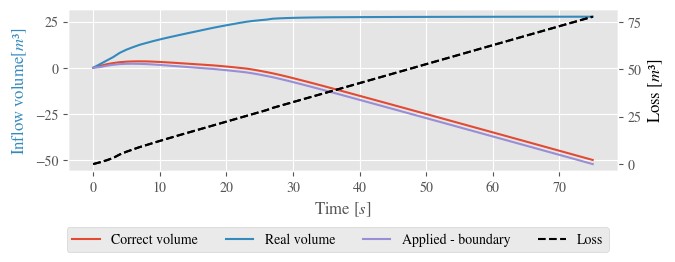

In [65]:
inch = 2.54
fig_size = 17
# fig_size = 34

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(times,correct_vols,label = 'Correct volume')
# ax.plot(times,np.array(correct_vols)-np.array(Q_in_cumsums),label = 'Coupled model')
ax.plot(times,real_vols,label = 'Real volume')

ax.set_ylabel('Inflow volume[$m³$]')
ax.set_xlabel('Time [$s$]')
ax.yaxis.label.set_color(ax.get_lines()[1].get_color())
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.plot(times, numpy.array(applied_inflows)+np.array(boundary_fluxs)-np.array(outfall_vols)-np.sum(Q_ins,axis = 1),label = 'Applied - boundary')

diff_ax = ax.twinx()
diff_ax.plot(times,losses,label = 'Loss',color = 'k',linestyle = '--')
diff_ax.plot(times,np.array(real_vols)- np.array(correct_vols),label = 'Loss',color = 'k',linestyle = '--')

diff_ax.grid(False)
diff_ax.set_ylabel('Loss [$m³$]')
diff_ax.yaxis.set_major_locator(plt.MaxNLocator(4))
# diff_ax.set_ylim([-0.5, 0.5])
# diff_ax.legend()

# ax.set_title(f'${baseline_flow}$m³/s on Inlet 1')
diff_ax.yaxis.label.set_color(diff_ax.get_lines()[0].get_color())
ax.plot([],[],color = 'k',linestyle = '--',label = 'Loss')
fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=2,ncol=4)
if False:
    # plt.savefig(plot_path +'vol_vs_method_' + plotname + '.eps',format = 'eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    # plt.savefig(plot_name + '.eps', bbox_inches='tight')
    # plt.savefig(plot_name + '.png', bbox_inches='tight')
    plt.savefig('plots/no_coupling_flooding_mass_conservation' + '.eps', bbox_inches='tight')
    plt.savefig('plots/no_coupling_flooding_mass_conservation' + '.png', bbox_inches='tight')

In [66]:
sewer_volume

6.974888857413426

In [67]:
total_volume_real

27.676543542701367

In [68]:
sewer_volume

6.974888857413426

In [69]:
domain_volume

20.70165468528794

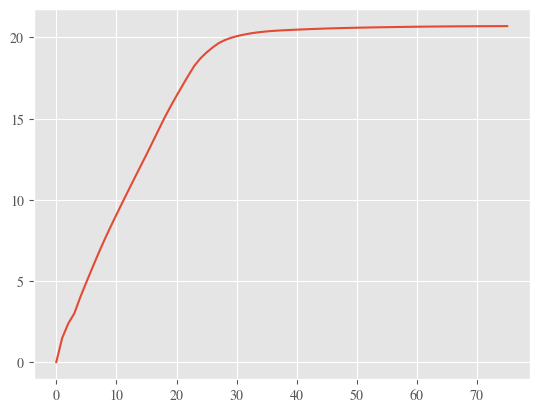

In [70]:
plt.plot(domain_volumes)

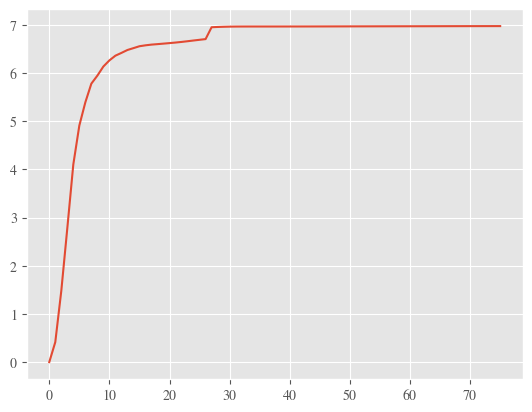

In [71]:
plt.plot(sewer_volumes)

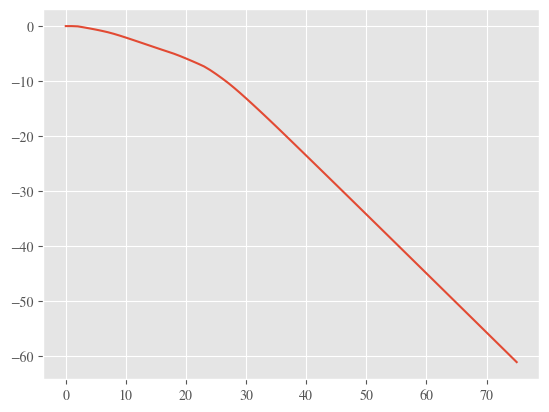

In [72]:
plt.plot(np.array(boundary_fluxs))

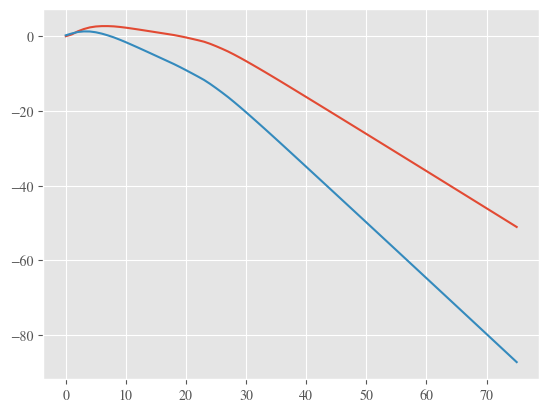

In [73]:
plt.plot(times, numpy.array(applied_inflows) + np.array(boundary_fluxs) - outfall_vols)
plt.plot(times, numpy.array(times)*baseline_flow + 0.5*baseline_flow+ np.array(boundary_fluxs) - outfall_vols)

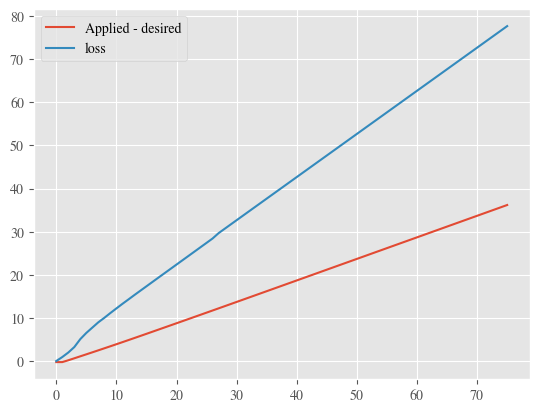

In [74]:
plt.plot(times, numpy.array(applied_inflows)-(numpy.array(times)*baseline_flow + 0.5*baseline_flow*dt),label =  'Applied - desired')
plt.plot(times,losses,label =  'loss')
plt.legend()


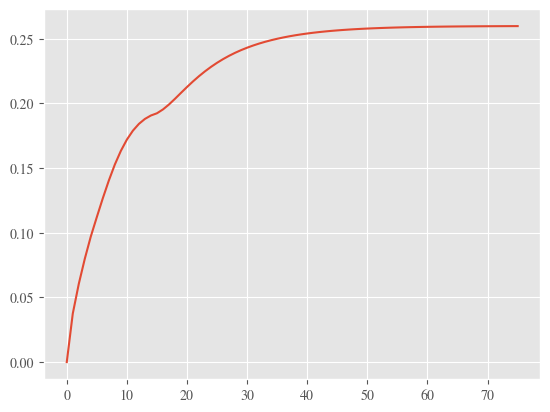

In [75]:
plt.plot(np.array(Q_ins)[:,1])

In [76]:
outfall_vol

63.83034352057215

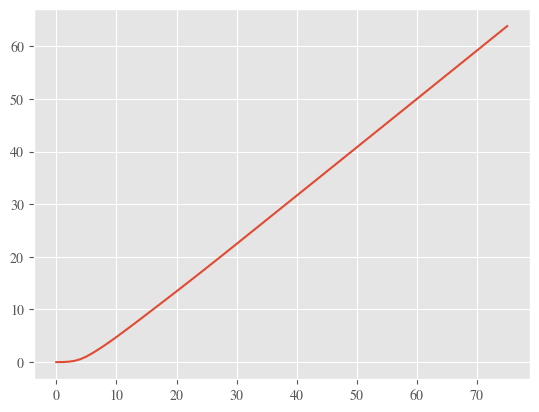

In [77]:
plt.plot(outfall_vols)

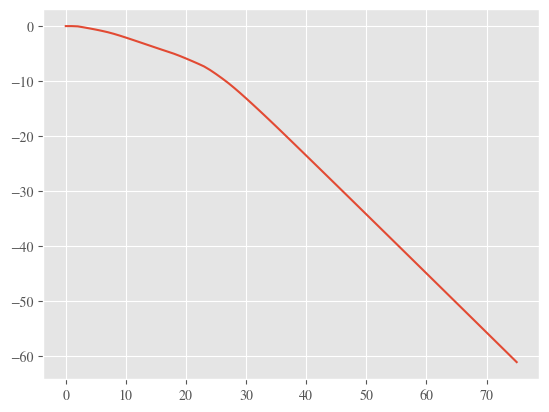

In [78]:
plt.plot(boundary_fluxs)   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


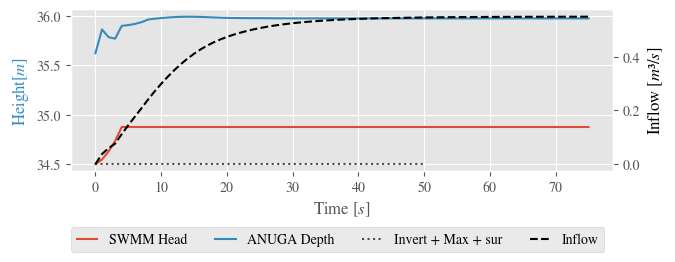

In [79]:
inch = 2.54
fig_size = 17
# fig_size = 34

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(times,np.array(node_heads)[:,2],label = 'SWMM Head')
# ax.plot(times,np.array(correct_vols)-np.array(Q_in_cumsums),label = 'Coupled model')
ax.plot(times,np.array(anuga_depths_out)[:,2] + inlet_elevation[2],label = 'ANUGA Depth')

ax.set_ylabel('Height[$m$]')
ax.set_xlabel('Time [$s$]')
ax.yaxis.label.set_color(ax.get_lines()[1].get_color())
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
# ax.plot([0,50],[invert_elev[2] + inp.junctions.loc['Inlet_3'].Max_Depth,invert_elev[2] + inp.junctions.loc['Inlet_3'].Max_Depth],color = [0.4,0.4,0.4],linestyle = ':',label = 'Invert + Max')
ax.plot([0,50],[invert_elev[2] + inp.junctions.loc['Inlet_3'].Max_Depth + inp.junctions.loc['Inlet_3'].Surcharge_Depth,invert_elev[2] + inp.junctions.loc['Inlet_3'].Max_Depth + inp.junctions.loc['Inlet_3'].Surcharge_Depth],color = [0.3,0.3,0.3],linestyle = ':',label = 'Invert + Max + sur')

diff_ax = ax.twinx()
diff_ax.plot(times,np.array(Q_ins)[:,2],label = 'Loss',color = 'k',linestyle = '--')
diff_ax.grid(False)
diff_ax.set_ylabel('Inflow [$m³/s$]')
diff_ax.yaxis.set_major_locator(plt.MaxNLocator(4))
# diff_ax.set_ylim([-0.5, 0.5])
# diff_ax.legend()

# ax.set_title(f'${baseline_flow}$m³/s on Inlet 3')
diff_ax.yaxis.label.set_color(diff_ax.get_lines()[0].get_color())
ax.plot([],[],color = 'k',linestyle = '--',label = 'Inflow')
fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)

plot_path + f'inflow_and_loss_inflow_{baseline_flow}_tavg_{time_average}_surd_{inp.junctions.loc["Inlet_3"].Surcharge_Depth}_maxd_{inp.junctions.loc["Inlet_3"].Max_Depth}'
if do_plot:
    # plt.savefig(plot_path +'vol_vs_method_' + plotname + '.eps',format = 'eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(plot_path + f'depths_inflow_inlet_3_{baseline_flow}_tavg_{time_average}_surd_{inp.junctions.loc["Inlet_3"].Surcharge_Depth}_maxd_{inp.junctions.loc["Inlet_3"].Max_Depth}.eps', bbox_inches='tight')
    plt.savefig(plot_path + f'depths_inflow_inlet_3_{baseline_flow}_tavg_{time_average}_surd_{inp.junctions.loc["Inlet_3"].Surcharge_Depth}_maxd_{inp.junctions.loc["Inlet_3"].Max_Depth}.png', bbox_inches='tight')


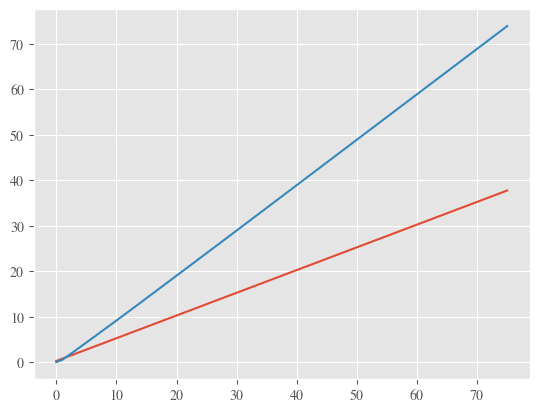

In [80]:
plt.plot(times, times * numpy.array(baseline_flow) + 0.5*baseline_flow)
plt.plot(times,applied_inflows)

In [81]:
Q_ins

[array([0., 0., 0., 0.]),
 array([0.0375, 0.0375, 0.0375, 0.0375]),
 array([0.05944748, 0.06048176, 0.05906656, 0.06070532]),
 array([0.07691768, 0.07989245, 0.07623923, 0.07894841]),
 array([0.09187987, 0.09713692, 0.11182887, 0.0941503 ]),
 array([0.1048561 , 0.11212602, 0.14503865, 0.10716435]),
 array([0.11573729, 0.12673031, 0.17682798, 0.11794604]),
 array([0.12454184, 0.14040208, 0.20822195, 0.1265159 ]),
 array([0.13147491, 0.15278916, 0.24055402, 0.1331791 ]),
 array([0.13690638, 0.16332599, 0.27101659, 0.13833795]),
 array([0.14115156, 0.17200907, 0.29939494, 0.14233373]),
 array([0.14443692, 0.17890462, 0.32586156, 0.14540107]),
 array([0.14693358, 0.18415813, 0.35039849, 0.14770904]),
 array([0.14879562, 0.18798938, 0.37287406, 0.14941269]),
 array([0.1501584 , 0.19064759, 0.39327835, 0.15065601]),
 array([0.15113975, 0.19235534, 0.41157014, 0.15156187]),
 array([0.15183853, 0.1953254 , 0.42776273, 0.15232381]),
 array([0.15232968, 0.1991544 , 0.44191973, 0.15358195]),
 arr

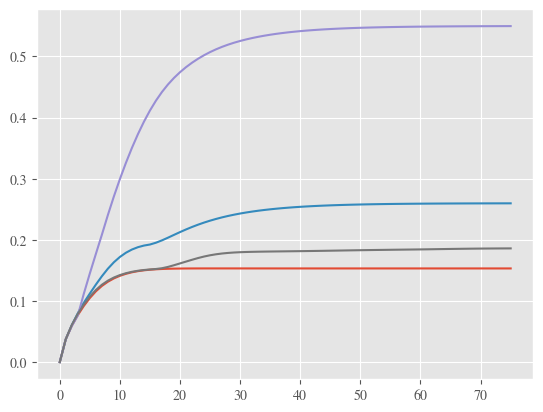

In [82]:
plt.plot(Q_ins)

In [83]:
inlet_elevation - node_heads[0]

array([1.09970619, 1.09666275, 1.12153967, 1.06923222])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


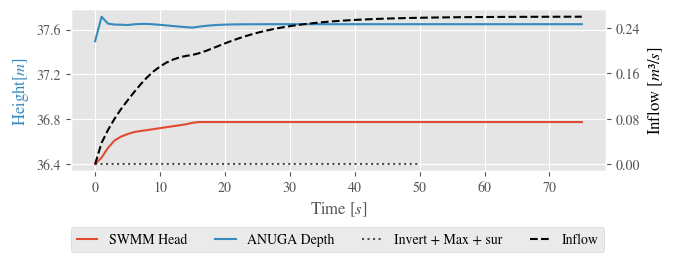

In [84]:
inch = 2.54
fig_size = 17
# fig_size = 34

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(times,np.array(node_heads)[:,1],label = 'SWMM Head')
# ax.plot(times,np.array(correct_vols)-np.array(Q_in_cumsums),label = 'Coupled model')
ax.plot(times,np.array(anuga_depths_out)[:,1] + inlet_elevation[1],label = 'ANUGA Depth')

ax.set_ylabel('Height[$m$]')
ax.set_xlabel('Time [$s$]')
ax.yaxis.label.set_color(ax.get_lines()[1].get_color())
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
# ax.plot([0,50],[invert_elev[1] + inp.junctions.loc['Inlet_2'].Max_Depth,invert_elev[1] + inp.junctions.loc['Inlet_2'].Max_Depth],color = [0.4,0.4,0.4],linestyle = ':',label = 'Invert + Max')
ax.plot([0,50],[invert_elev[1] + inp.junctions.loc['Inlet_2'].Max_Depth + inp.junctions.loc['Inlet_2'].Surcharge_Depth, invert_elev[1] + inp.junctions.loc['Inlet_2'].Max_Depth + inp.junctions.loc['Inlet_2'].Surcharge_Depth],color = [0.3,0.3,0.3],linestyle = ':',label = 'Invert + Max + sur')

diff_ax = ax.twinx()
diff_ax.plot(times,np.array(Q_ins)[:,1],label = 'Loss',color = 'k',linestyle = '--')
diff_ax.grid(False)
diff_ax.set_ylabel('Inflow [$m³/s$]')
diff_ax.yaxis.set_major_locator(plt.MaxNLocator(4))
# diff_ax.set_ylim([-0.5, 0.5])
# diff_ax.legend()

diff_ax.yaxis.label.set_color(diff_ax.get_lines()[0].get_color())
ax.plot([],[],color = 'k',linestyle = '--',label = 'Inflow')
fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)
if do_plot:
    # plt.savefig(plot_path +'vol_vs_method_' + plotname + '.eps',format = 'eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(plot_path + f'depths_inflow_inlet_2_{baseline_flow}_tavg_{time_average}_surd_{inp.junctions.loc["Inlet_3"].Surcharge_Depth}_maxd_{inp.junctions.loc["Inlet_3"].Max_Depth}.eps', bbox_inches='tight')
    plt.savefig(plot_path + f'depths_inflow_inlet_2_{baseline_flow}_tavg_{time_average}_surd_{inp.junctions.loc["Inlet_3"].Surcharge_Depth}_maxd_{inp.junctions.loc["Inlet_3"].Max_Depth}.png', bbox_inches='tight')



In [85]:
if do_data_save and False:

    pick = outname + '.dat'

    data = {'times':times, 'conduit_depths':conduit_depths, 'node_heads':node_heads, 'Q_in':Q_in, 'inlet_vol_sum':sum(inlet_vol) }

    with open(pick, "wb") as f:
        pickle.dump(data, f)